# <span style="color:red">2D Collision- Four_Momentum_lab for Annihilation and Compton Scattering</span>



#### <span style="color:red">This notebook is aimed to act as a python alternative to the interactive software for the same lab used in Mac Classic. Here, the code asks for inputs from the user regarding two body collision. They can be either among momentum, energy, mass or angle of incidence/scattering. After the input, the notebook shows how to investigate for the after effects of the collision and provide adequate visualization and output results</span>

## <span style="color:red">Calling libraries and important functions</span>

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import fsolve
import warnings
from scipy.optimize import least_squares
import time
import sys
warnings.filterwarnings("ignore")
from matplotlib.animation import FuncAnimation
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def convert_string_float(a):
    # Create a new array with the same shape but with data type float
    result = np.empty_like(a, dtype=float)
    
    # Iterate over the array elements
    for i in range(len(a)):
        # If the element is 'no', replace it with NaN
        if a[i] == 'no':
            result[i] = np.nan
        else:
            result[i]=round(float(a[i]),4)
    
    return result

def sin(x):
    return np.sin(np.deg2rad(x))

def cos(x):
    return np.cos(np.deg2rad(x))


def tan(x):
    return np.tan(np.deg2rad(x))


## <span style="color:blue">Asking User to Input data</span>




#### <span style="color:purple">Here you will be entering data for before and after collision in terms of m, E, P and θ. **Enter the string input 'no' if it is a missing field value**</span>

In [2]:
print('First, Enter data for before collision (NOTE: Energy and mass values have to be positive)')
print('Enter data for Particle 1 (Here Particle 1 refers to one coming from positive x-axis before collision), in the order of Mass(M),Energy(E),Momentum(P) and θ (degree). If you do \
not have the value write "no". Also, if you have mis-typed anything you have to re-enter the values again from scratch.')
m1i,E1i,P1i,theta1i= [s for s in input().split()]
print('Enter data for Particle 2 (Here Particle 2 refers to one coming from negative x-axis before collision), in the order of Mass(M),Energy(E),Momentum(P) and θ (degree).If you do \
not have the value write no')
m2i,E2i,P2i,theta2i= [s for s in input().split()]
## Input data for after collision
print('Now, let\'s Enter data for after collision (NOTE: Energy and mass values have to be positive)')
print('Enter data for Particle 3 (Here Particle 3 refers to the one that is the aftermath of particle 1 after collision), in the order of Mass(M),Energy(E),Momentum(P) and θ (degree). If you do \
not have the value write no')
m3f,E3f,P3f,theta3f= [s for s in input().split()]
print('Enter data for Particle 4 (Here Particle 4 refers to the one that is the aftermath of particle 2 after collision), in the order of Mass(M),Energy(E),Momentum(P) and θ (degree). If you do \
not have the value write no')
m4f,E4f,P4f,theta4f= [s for s in input().split()]



First, Enter data for before collision (NOTE: Energy and mass values have to be positive)
Enter data for Particle 1 (Here Particle 1 refers to one coming from positive x-axis before collision), in the order of Mass(M),Energy(E),Momentum(P) and θ (degree). If you do not have the value write "no". Also, if you have mis-typed anything you have to re-enter the values again from scratch.


 1 1.5 no 0


Enter data for Particle 2 (Here Particle 2 refers to one coming from negative x-axis before collision), in the order of Mass(M),Energy(E),Momentum(P) and θ (degree).If you do not have the value write no


 1 1.5 no 180


Now, let's Enter data for after collision (NOTE: Energy and mass values have to be positive)
Enter data for Particle 3 (Here Particle 3 refers to the one that is the aftermath of particle 1 after collision), in the order of Mass(M),Energy(E),Momentum(P) and θ (degree). If you do not have the value write no


 0.5 no no -90


Enter data for Particle 4 (Here Particle 4 refers to the one that is the aftermath of particle 2 after collision), in the order of Mass(M),Energy(E),Momentum(P) and θ (degree). If you do not have the value write no


 0.5 no no no


#### <span style="color:red">Display the input data in form of a table. **Just run this code chunk to execute the module to display the entered data in tabular format**</span>

In [3]:
## Let's display the data supplied in the form of a table

df1=pd.DataFrame({
    "Mass(M)":[m1i,m2i,m3f,m4f],
    "Energy(E)":[E1i,E2i,E3f,E4f],
    "Momentum(P)":[P1i,P2i,P3f,P4f],
    'Angle(θ)':[theta1i,theta2i,theta3f,theta4f]
}, index=['Particle 1','Particle 2','Particle 3','Particle 4'])


df1_first_part = df1.iloc[:2]
df1_second_part = df1.iloc[2:].copy()
df_modified = pd.concat([df1_first_part, df1_second_part],keys=['Before Collision','After Collision'])
#df_modified=df_modified.replace('no','')
display(df_modified)

variables_with_no = df_modified.columns[(df_modified == 'no').any()].tolist()
print("The columns with having missing entries are:")
print(','.join(variables_with_no))

Mass(M) Energy(E) Momentum(P) Angle(θ)
Before Collision Particle 1       1       1.5          no        0
                 Particle 2       1       1.5          no      180
After Collision  Particle 3     0.5        no          no      -90
                 Particle 4     0.5        no          no       no

The columns with having missing entries are:
Energy(E),Momentum(P),Angle(θ)


#### <span style="color:red">Function to solve for missing entries before collision. **Please make sure to run and initialize this function**</span>

In [4]:
## Physics calculations
def solver_before_collision(m1i,m2i,E1i,E2i,P1i,P2i,theta1i,theta2i,df):
    
    #calculating unknowns for before collision
    first_row=np.array(df.iloc[0,:4].values)
    second_row=np.array(df.iloc[1,:4].values)
    variables_1=[('m',first_row[0]),('E',first_row[1]),('p',first_row[2]),('t',first_row[3])]
    variables_2=[('m',second_row[0]),('E',second_row[1]),('p',second_row[2]),('t',second_row[3])]
    variables_1=[list(item) for item in variables_1]
    variables_2=[list(item) for item in variables_2]
    for var in variables_1:
        var_name, value = var
        if 'no' in value:
            if var_name == 'p':
                new_value = round((np.sqrt(float(first_row[1])**2 - float(first_row[0])**2)),4)
                #print(new_value, var_name)
                var[1] = new_value  # Update the value in the list directly
            elif var_name == 'm':
                new_value = round((np.sqrt(float(first_row[1])**2 - float(first_row[2])**2)),4)
                var[1] = new_value # Convert to string if needed
            elif var_name == 'E':
                new_value = round((np.sqrt(float(first_row[0])**2 + float(first_row[2])**2)),4)
                var[1] = new_value
        else:
            pass

    for var_2 in variables_2:
        var_name_2, value_2 = var_2
        if 'no' in value_2:
            if var_name_2 == 'p':
                 new_value = round((np.sqrt(float(second_row[1])**2 - float(second_row[0])**2)),4)
                # print(new_value, var_name)
                 var_2[1] = new_value  # Update the value in the list directly
            elif var_name_2 == 'm':
                 new_value = round((np.sqrt(float(second_row[1])**2 - float(second_row[2])**2)),4)
                 var_2[1] = new_value  # Convert to string if needed
            elif var_name_2 == 'E':
                new_value =round((np.sqrt(float(second_row[0])**2 + float(second_row[2])**2)),4)
                var_2[1] = new_value
        else:
             pass
    variables_1 = [tuple(item) for item in variables_1]
    variables_2 = [tuple(item) for item in variables_2] 

    df_bef = pd.DataFrame([dict(variables_1),dict(variables_2)],index=['Particle 1','Particle 2'])
    df_bef.columns=['Mass(M)','Energy(E)','P','θ']
   
    
    return variables_1,variables_2, df_bef
    


#### <span style="color:red">Run the following cell to invoke the above function and display completed table for before collision</span>

In [5]:
#The function solver_before_collision helps to evaluate the missing variables for before collision
print('These are the completed entries for before collision') 
return_values=solver_before_collision(m1i,m2i,E1i,E2i,P1i,P2i,theta1i,theta2i,df_modified)
df_before=return_values[2]
print(df_before)

These are the completed entries for before collision
           Mass(M) Energy(E)      P    θ
Particle 1       1       1.5  1.118    0
Particle 2       1       1.5  1.118  180


#### <span style="color:red">Calculate for the total energy and momentum of the system before collision</span>

In [6]:

## Let's solve for the momentum conservation in two dimensions
#First let's vertically add quantities to determine total sum for conservation of energy and momentum

energy_sum= float(return_values[2].iloc[0,1])+float(return_values[2].iloc[1,1])
momen_sum= float(return_values[2].iloc[0,2])+float(return_values[2].iloc[1,2])
if energy_sum >= 0:
    print('Total initial energy of the system:',energy_sum,'SI units')
else:
     print('There is something wrong in the entry values for energy')
if momen_sum >= 0:
    print('Total initial momen of the system:',momen_sum,'SI units')
else:
    print('There is something wrong in the entry values for momentum')

m1i,E1i,P1i,theta1i  =[var[1] for var in return_values[0]]
m2i,E2i,P2i,theta2i  =[var[1] for var in return_values[1]]
[P1i,P2i,theta1i,theta2i,E1i,E2i,m2i,m1i]=convert_string_float([P1i,P2i,theta1i,theta2i,E1i,E2i,m2i,m1i])
[P3f,P4f,theta3f,theta4f,E3f,E4f,m3f,m4f]=convert_string_float([P3f,P4f,theta3f,theta4f,E3f,E4f,m3f,m4f])

Total initial energy of the system: 3.0 SI units
Total initial momen of the system: 2.236 SI units


### <span style="color:blue">Function to solve for missing entries **after** collision.</span>


#### <span style="color:purple">**NOTE: There is a part where user has to manually edit this code chunk. Under the function equations, one has to type in the variable names which are unknown for the after collision scenario. It is recommended that the order of unknown variables is followed from left to right as is displayed in the table. For example, it may be in the order of energy(E), momentum(P) and angle(theta). Please make sure to copy and paste this order of variables in the line below the solution variable declaration.**</span>

In [7]:
def solver_after_collision(P3f,P4f,theta3f,theta4f,E3f,E4f,in_arr):
   

    final_array=np.array([P3f,P4f,theta3f,theta4f,E3f,E4f])
    count = sum(1 for element in final_array if np.isnan(element))
    #ul=list(ele for ele in final_array if np.isnan(ele))
    if count==5:
       print('There are',count,'unknowns and 5 equations. Hence, it can be solved completely')
    elif count > 5:
       print('Warning: There are more unknown variables and hence we are unable to solve and proceed. Please supply additional information in either P3f,P4f, theta3f or theta4f ')
       #sys.exit(1)
    elif count < 5:
       print('Warning: There are more equations than number of unknown vars. So, there might not be optimized solutions that are obatinable from the equations')
       #sys.exit(1)


    print('Solving of equations start....')
    start_time= time.time()

    
    # ****** Here is below where you need to edit manually in the program. Please just enter the unknown variables in the first line under the function 
    # `def equations()`. It is desirable that you enter those variables in the order of E,P and theta (it is because M values will be provided always) *****
    
    def equations(vars):
        #*******************************************************************************************************************************************
        E3f,E4f,P3f,P4f,theta4f= vars
        #*******************************************************************************************************************************************
        eq1= P1i*cos(theta1i) + P2i*cos(theta2i) - P3f*cos(theta3f) - P4f*cos(theta4f) #equation 1
        eq2 = P1i*sin(theta1i) + P2i*sin(theta2i) - P3f*sin(theta3f) - P4f*sin(theta4f) #equation 2
        eq3 = (E3f**2)- (P3f**2)-(m3f**2) #equation 3
        eq4 = E4f + E3f - E1i-E2i #equation 4
        eq5 = (E4f**2)- (P4f**2)-(m4f**2) #equation 5
        return [ eq1,eq2,eq3,eq4,eq5]

    
    # Initial guess for the variables
    # The user needs to enter the initial guesses within a reasonable limit
    # initial guess
    initial_guess = in_arr

    # Use least_squares to optmize the vector of residuals. Enter here the lower and upper bounds for your paramters
    #************************************************************************************************************************************************
    lower_bounds = [0,0,0,0,-180]
    upper_bounds = [float('inf'), float('inf'), float('inf'), float('inf'),180]
    #************************************************************************************************************************************************
    solution= least_squares(equations,initial_guess,bounds=(lower_bounds,upper_bounds))
    print('Solving finished')
    print("Time taken to solve ----- %s seconds -----" % np.round((time.time()-start_time),4))
    print('The entries after collision are:')


    
    #User should copy and paste the unknown variables list in the same order as mentioned in the function equations
    #**********************************************************************************************************************************************
    E3f,E4f,P3f,P4f,theta4f=[np.round(i,3) for i in solution.x]             #solution.x [round(i,4) for i in solution]
    #**********************************************************************************************************************************************


    
    variables_1=[('m',m3f),('E',abs(E3f)),('p',abs(P3f)),('t',theta3f)]
    variables_2=[('m',m4f),('E',abs(E4f)),('p',abs(P4f)),('t',theta4f)]

    df_aft = pd.DataFrame([dict(variables_1),dict(variables_2)],index=['Particle 3','Particle 4'])
    df_aft.columns=['Mass(M)','Energy(E)','P','θ']
    return df_aft,variables_1,variables_2

#### <span style="color:blue">Run the next code chunk to display the solved values after executing the previous cell. The code will ask you how many unknown variables are you solving for. Enter the number. After that the solver will ask to enter initial guess values for those variables. These are the initial approximate values that you should provide within reasonable range. You will find the suggested range and values in the question prompt below.</span>

In [8]:
print('These are the completed entries for before collision') 
print(df_before)
N=int(input('Enter the no. of unknown vars'))
print('Enter your initial guesses for the parameters: (For e.g. if it is P or E, a good value to start maybe 0 and if it is θ, it can be 30')
guess_input=[]
for i in range(0,N):
    ele=(input())
    guess_input.append(ele)

guess_input=convert_string_float(guess_input)
return_values=solver_after_collision(P3f,P4f,theta3f,theta4f,E3f,E4f,guess_input)
df_after=return_values[0]
m3f,E3f,P3f,theta3f  =[np.round(var[1],3) for var in return_values[1]]
m4f,E4f,P4f,theta4f  =[np.round(var[1],3) for var in return_values[2]]
print(df_after)


These are the completed entries for before collision
           Mass(M) Energy(E)      P    θ
Particle 1       1       1.5  1.118    0
Particle 2       1       1.5  1.118  180


Enter the no. of unknown vars 5


Enter your initial guesses for the parameters: (For e.g. if it is P or E, a good value to start maybe 0 and if it is θ, it can be 30


 0
 0
 0
 0
 30


There are 5 unknowns and 5 equations. Hence, it can be solved completely
Solving of equations start....
Solving finished
Time taken to solve ----- 0.1319 seconds -----
The entries after collision are:
            Mass(M)  Energy(E)      P     θ
Particle 3      0.5        1.5  1.414 -90.0
Particle 4      0.5        1.5  1.414  90.0


#### <span style="color:red"> This code chunk saves your angle of scattering and energy after collision data to a file named after your choice for further analysis in the future</span> 

In [9]:
path=os.getcwd()+'/'+'Output_{}.txt'.format(E1i)
check_file=os.path.isfile(path)
if not check_file:
    with open('Output_{}.txt'.format(E1i),'w') as file:
        _=file.write('theta3f Energy3f theta4f Energy4f \n')
        file.close()
else:
    pass
user_input=input('Do you want to add your data to the Output file?Y or N').lower()
if user_input=='y':
    print('Added! You will have an opportunity to plot the data from the output file later in the script')
    with open('Output_{}.txt'.format(E1i),'a+') as file:
        _=file.write('{} {} {} {} \n'.format(theta3f,E3f,theta4f,E4f))
else:
    pass
    print('Ok! Move on to the next cell')

Do you want to add your data to the Output file?Y or N y


Added! You will have an opportunity to plot the data from the output file later in the script


## <span style="color:red">ANIMATION</span>

#### <span style="color:red">This part of the code creates an animation/video clip of the collision event, ranging from showing the exact path trajectories and angle orientations of the particles before to after the collision</span>

In [9]:
#plt.close('all')
%matplotlib qt
Px_bef_1= P1i*cos(theta1i) 
Px_bef_2= P2i*cos(theta2i)
Px_aft_3= P3f*cos(theta3f)
Px_aft_4= P4f*cos(theta4f)
Py_bef_1= P1i*sin(theta1i) 
Py_bef_2= P2i*sin(theta2i)
Py_aft_3= P3f*sin(theta3f)
Py_aft_4= P4f*sin(theta4f)
use_input=input('Do you want to play the animation? Y or N')


if use_input=='Y' or use_input=='y':
    frame_input=int(input('What is the no.of frames you want? The higher the number, the slower the video'))
    frames= frame_input
    # Calculate distances
    dist1 = 2*np.sqrt(Px_bef_1**2 + Py_bef_1**2)
    dist2 = 2*np.sqrt(Px_bef_2**2 + Py_bef_2**22)
    dist3 = 2*np.sqrt(Px_aft_3**2 + Py_aft_3**2)
    dist4 = 2*np.sqrt(Px_aft_4**2 + Py_aft_4**2)


    # Calculate lengths per frame
    l1 = 2* dist1 / frames
    l2 = 2* dist2 / frames
    l3 = 2* dist3 / frames
    l4 = 2* dist4 / frames

    def title():
        if m1i==m2i:
            return 'Annihilation'
        else:
            return 'Compton Scattering'



    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))
    _=scat1 = ax.scatter([], [], s=(m1i+0.5)*100, c='r', marker='o')
    _=text1 = ax.text(0, 0, '', ha='center')
    _=scat2 = ax.scatter([], [], s=(m2i+0.5)*100, c='g', marker='o')
    _=text2 = ax.text(0, 0, '', ha='center')
    _=scat3 = ax.scatter([],[],s=(m3f+0.5)*100,c='y',marker='o')
    _=text3=  ax.text(0,0,'',ha='center')
    _=scat4 = ax.scatter([],[],s=(m4f+0.5)*100,c='b',marker='o')
    _=text4=  ax.text(0,0,'',ha='center')
    _=ax.set_xlim(-6, 6)
    _=ax.set_ylim(-6, 6)
    _=ax.set_title(title())

    def init():
        """Initialize the background of the animation."""
        scat1.set_offsets(np.empty((0, 2)))
        text1.set_position((0,0))
        scat2.set_offsets(np.empty((0, 2)))
        text2.set_position((0,0))
        scat3.set_offsets(np.empty((0, 2)))
        text3.set_position((0,0))
        scat4.set_offsets(np.empty((0, 2)))
        text4.set_position((0,0))
        return scat1, text1, scat2, text2,scat3,text3,scat4,text4


    def update(frame):
        """Update the scatter plot for each frame."""
        if frame < frames/2:
            current_dist1 = dist1 - frame * l1
            current_dist2 = dist2 - frame * l2
            i, j = round(-current_dist1 * cos(theta1i), 3), round(current_dist1 * sin(theta1i), 3)
            k, l = round(-current_dist2 * cos(theta2i), 3), round(current_dist2 * sin(theta2i), 3)
            scat1.set_offsets(np.array([[i, j]]))
            text1.set_position((i, j))
            text1.set_text('1')
            scat2.set_offsets(np.array([[k, l]]))
            text2.set_position((k, l))
            text2.set_text('2')
        
        else:
            current_dist3 =  frame * l3
            current_dist4 =  frame * l4
            m,n =  round(current_dist3 * cos(theta3f), 3), round(current_dist3 * sin(theta3f), 3)
            p,q =  round(current_dist4 * cos(theta4f), 3), round(current_dist4 * sin(theta4f), 3)
            scat3.set_offsets(np.array([[m,n]]))
            text3.set_position((m, n))
            text3.set_text('3')
            scat4.set_offsets(np.array([[p, q]]))
            text4.set_position((p, q))
            text4.set_text('4')  
        
    
        return scat1, text1, scat2, text2,scat3,text3,scat4,text4

    # Create the animation
    ani = FuncAnimation(fig, update, frames=frames, init_func=init, blit=True, repeat=False)
    plt.show()
    
else:
    print('End of the simulation')
    pass



Do you want to play the animation? Y or N y
What is the no.of frames you want? The higher the number, the slower the video 50


# <span style="color:red"> Energy(E)-Momentum(P) diagnostic plots </span>

#### <span style="color:red">This code chunk allows you to see/create a particuar visualization of your choice and alos save it for future use </span>

In [13]:


%matplotlib widget
user_input=input('Which Plot do you want?:1:3D, 2:Py-Px 3:E-Px 4:E-Py')
if user_input=='2':
    fig, (ax1, ax2) = plt.subplots(1, 2,num='Px-Py',figsize=(12, 6))
    _=ax1.plot(Px_bef_1,Py_bef_1,'ro')
    _=ax1.text(Px_bef_1,Py_bef_1,'1')
    _=ax1.plot(Px_bef_2,Py_bef_2,'go')
    _=ax1.text(Px_bef_2,Py_bef_2,'2')
    _=ax1.spines['left'].set_position(('data', 0))
    _=ax1.spines['bottom'].set_position(('data', 0))
    _=ax1.spines['right'].set_color('none')
    _=ax1.spines['top'].set_color('none')
    _=ax1.xaxis.set_ticks_position('bottom')
    _=ax1.yaxis.set_ticks_position('left')
 
    _=ax2.plot(Px_aft_3,Py_aft_3,'yo')
    _=ax2.text(Px_aft_3,Py_aft_3,'3')
    _=ax2.plot(Px_aft_4,Py_aft_4,'bo')
    _=ax2.text(Px_aft_4,Py_aft_4,'4')
    _=ax2.spines['left'].set_position(('data', 0))
    _=ax2.spines['bottom'].set_position(('data', 0))
    _=ax2.spines['right'].set_color('none')
    _=ax2.spines['top'].set_color('none')
    _=ax2.xaxis.set_ticks_position('bottom')
    _=ax2.yaxis.set_ticks_position('left')

    _=ax1.set_xlim(-3,3)
    _=ax1.set_ylim(-3,3)
    _=ax2.set_xlim(-3,3)
    _=ax2.set_ylim(-3,3)
    _=ax1.set_title('Before Collision')
    _=ax2.set_title('After Collision')
    _=ax1.set_xlabel('Px',loc='right')
    _=ax1.set_ylabel('Py',loc='top')
    _=ax2.set_xlabel('Px',loc='right')
    _=ax2.set_ylabel('Py',loc='top')
    _=fig.suptitle('Px-Py plot')
    plt.tight_layout()
    plt.show()
elif user_input=='3':
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6),num='E-Px')
    _=ax1.axline([0, 0], [1, 1],color='orange')
    _=ax1.axline([0, 0], [-1, 1],color='orange')
    _=ax1.plot([0,Px_bef_1],[0,E1i],'ro-')
    _=ax1.text(Px_bef_1,E1i,'1')
    _=ax1.plot([0,Px_bef_2],[0,E2i],'go-')
    _=ax1.text(Px_bef_2,E2i,'2')
    _=ax1.spines['left'].set_position(('data', 0))
    _=ax1.spines['bottom'].set_position(('data', 0))
    _=ax1.spines['right'].set_color('none')
    _=ax1.spines['top'].set_color('none')
    _=ax1.xaxis.set_ticks_position('bottom')
    _=ax1.yaxis.set_ticks_position('left')

    _=ax2.axline([0, 0], [1, 1],color='orange')
    _=ax2.axline([0, 0], [-1, 1],color='orange')
    _=ax2.plot([0,Px_aft_3],[0,E3f],'yo-')
    _=ax2.text(Px_aft_3,E3f,'3')
    _=ax2.plot([0,Px_aft_4],[0,E4f],'bo-')
    _=ax2.text(Px_aft_4,E4f,'4')
    _=ax2.spines['left'].set_position(('data', 0))
    _=ax2.spines['bottom'].set_position(('data', 0))
    _=ax2.spines['right'].set_color('none')
    _=ax2.spines['top'].set_color('none')
    _=ax2.xaxis.set_ticks_position('bottom')
    _=ax2.yaxis.set_ticks_position('left')

    _=ax1.set_xlim(-3,3)
    _=ax1.set_ylim(-0,3)
    _=ax2.set_xlim(-3,3)
    _=ax2.set_ylim(0,3)
    _=ax1.set_title('Before Collision')
    _=ax2.set_title('After Collision')
    _=ax1.set_xlabel('Px',loc='right')
    _=ax1.set_ylabel('E',loc='top')
    _=ax2.set_xlabel('Px',loc='right')
    _=ax2.set_ylabel('E',loc='top')
    _=fig.suptitle('E-Px plot')
    plt.tight_layout()
    plt.show()
elif user_input=='4':
    fig, (ax1, ax2) = plt.subplots(1, 2,num='E-Py', figsize=(12, 6))
    _=ax1.axline([0, 0], [1, 1],color='orange')
    _=ax1.axline([0, 0], [-1, 1],color='orange')
    _=ax1.plot([0,Py_bef_1],[0,E1i],'ro-')
    _=ax1.text(Py_bef_1,E1i,'1')
    _=ax1.plot([0,Py_bef_2],[0,E2i],'go-')
    _=ax1.text(Py_bef_2,E2i,'2')
    _=ax1.spines['left'].set_position(('data', 0))
    _=ax1.spines['bottom'].set_position(('data', 0))
    _=ax1.spines['right'].set_color('none')
    _=ax1.spines['top'].set_color('none')
    _=ax1.xaxis.set_ticks_position('bottom')
    _=ax1.yaxis.set_ticks_position('left')

    _=ax2.axline([0, 0], [1, 1],color='orange')
    _=ax2.axline([0, 0], [-1, 1],color='orange')
    _=ax2.plot([0,Py_aft_3],[0,E3f],'yo-')
    _=ax2.text(Py_aft_3,E3f,'3')
    _=ax2.plot([0,Py_aft_4],[0,E4f],'bo-')
    _=ax2.text(Py_aft_4,E4f,'4')
    _=ax2.spines['left'].set_position(('data', 0))
    _=ax2.spines['bottom'].set_position(('data', 0))
    _=ax2.spines['right'].set_color('none')
    _=ax2.spines['top'].set_color('none')
    _=ax2.xaxis.set_ticks_position('bottom')
    _=ax2.yaxis.set_ticks_position('left')

    _=ax1.set_xlim(-3,3)
    _=ax1.set_ylim(-0,3)
    _=ax2.set_xlim(-3,3)
    _=ax2.set_ylim(0,3)
    _=ax1.set_title('Before Collision')
    _=ax2.set_title('After Collision')
    _=ax1.set_xlabel('Py',loc='right')
    _=ax1.set_ylabel('E',loc='top')
    _=ax2.set_xlabel('Py',loc='right')
    _=ax2.set_ylabel('E',loc='top')
    _=fig.suptitle('E-Py plot')
    plt.tight_layout()
    plt.show()
elif user_input=='1':
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,5),subplot_kw=dict(projection='3d'))

# syntax for 3-D projection
    _=ax1.plot3D(Px_bef_1,Py_bef_1,E1i,'ro-')
    _=ax1.text(Px_bef_1,Py_bef_1,E1i,'1')
    _=ax1.plot(Px_bef_2,Py_bef_2,E2i,'go-')
    _=ax1.text(Px_bef_2,Py_bef_2,E2i,'2')

    _=ax1.set_xlabel('Px')
    _=ax1.set_ylabel('Py')
    _=ax1.set_zlabel('E')
    _=ax1.set_xlim(-3,3)
    _=ax1.set_ylim(-3,3)
    _=ax1.set_zlim(0,3)
    #_=ax1.grid(color='orange')

    _=ax2.plot3D(Px_aft_3,Py_aft_3,E3f,'yo-')
    _=ax2.text(Px_aft_3,Py_aft_3,E3f,'3')
    _=ax2.plot(Px_aft_4,Py_aft_4,E4f,'bo-')
    _=ax2.text(Px_aft_4,Py_aft_4,E4f,'4')
    _=ax2.set_xlabel('Px')
    _=ax2.set_ylabel('Py')
    _=ax2.set_zlabel('E')
    _=ax2.set_xlim(-3,3)
    _=ax2.set_ylim(-3,3)
    _=ax2.set_zlim(0,3)
    plt.show()
    


Which Plot do you want?:1:3D, 2:Py-Px 3:E-Px 4:E-Py 2


## <span style="color:red"> Jump to different particle frame </span>
        

#### <span style="color:red"> We will find here how the four momentum vector changes in another frame </span>

In [14]:
#Define the energy momentum vectors


p1=np.array([E1i,P1i*cos(theta1i),P1i*sin(theta1i),0])
p2=np.array([E2i,P2i*cos(theta2i),P2i*sin(theta2i),0])
p3=np.array([E3f,P3f*cos(theta3f),P3f*sin(theta3f),0])
p4=np.array([E4f,P4f*cos(theta4f),P4f*sin(theta4f),0])


c=1 #define the speed of light
P_total = p1[1:] + p2[1:]  # Sum of momenta (p_x, p_y, p_z)
E_total = p1[0] + p2[0]    # Sum of energies

# Magnitude of total momentum
P_total_mag = np.linalg.norm(P_total)

# Calculate the velocity v of the system frame relative to the lab frame
beta = P_total_mag / E_total  # Dimensionless velocity (v/c)
v = beta * c  # Actual velocity in m/s
gamma = 1 / np.sqrt(1 - beta**2)
direction = P_total / P_total_mag




#Checking which type of collision:
if m1i==m2i:
    print('This is Annihilation collision type')
    if P1i==P2i:
        print('We are in system frame. Which frame you want to go to: Particle 1 (type p1) or Particle 2 (type p2)')
        user_input=(input('Enter'))
        value= globals()[user_input]
        v_com=  np.linalg.norm(value[1:]) / value[0] * c
        beta_com = v_com / c  # Dimensionless velocity (v/c)
        direction_com = -value[1:] / np.linalg.norm(value[1:]) 
        gamma_com = 1 / np.sqrt(1 - beta_com**2)
        Lambda_rest = np.array([
            [gamma_com, gamma_com * beta_com * direction_com[0], gamma_com * beta_com * direction_com[1], gamma_com * beta_com * direction_com[2]],
            [gamma_com * beta_com * direction_com[0], 1 + (gamma_com - 1) * (direction_com[0] ** 2), (gamma_com - 1) * direction_com[0] * direction_com[1], (gamma_com - 1) * direction_com[0] * direction_com[2]],
            [gamma_com * beta_com * direction_com[1], (gamma_com - 1) * direction_com[1] * direction_com[0], 1 + (gamma_com - 1) * (direction_com[1] ** 2), (gamma_com - 1) * direction_com[1] * direction_com[2]],
            [gamma_com * beta_com * direction_com[2], (gamma_com - 1) * direction_com[2] * direction_com[0], (gamma_com - 1) * direction_com[2] * direction_com[1], 1 + (gamma_com - 1) * (direction_com[2] ** 2)]
        ])


        p1_rest = np.dot(Lambda_rest, p1)
        p2_rest = np.dot(Lambda_rest, p2)
        p3_rest = np.dot(Lambda_rest, p3)
        p4_rest = np.dot(Lambda_rest, p4)

        
        E1i_new,E2i_new,E3f_new,E4f_new= np.round(p1_rest[0],3),np.round(p2_rest[0],3),np.round(p3_rest[0],3),np.round(p4_rest[0],3)
        P1i_new,P2i_new,P3f_new,P4f_new= np.round(np.linalg.norm(p1_rest[1:]),3),np.round(np.linalg.norm(p2_rest[1:]),3),np.round(np.linalg.norm(p3_rest[1:]),3),np.round(np.linalg.norm(p4_rest[1:]),3)
        theta1i_new,theta2i_new,theta3f_new,theta4f_new= np.round(np.degrees(np.arctan(p1_rest[2]/p1_rest[1])),3),np.round(np.degrees(np.arctan(p2_rest[2]/p2_rest[1])),3),np.round(np.degrees(np.arctan(p3_rest[2]/p3_rest[1])),3),np.round(np.degrees(np.arctan(p4_rest[2]/p4_rest[1])),3)
        print(f"E,P and theta for Particle 1 in rest frame:", np.round(p1_rest[0],3), np.round(np.linalg.norm(p1_rest[1:]),3),np.round(np.degrees(np.arctan(p1_rest[2]/p1_rest[1])),3) if p1_rest[1]!=0 else 0 )
        print(f"E,P and theta for Particle 2 in rest frame:",np.round(p2_rest[0],3), np.round(np.linalg.norm(p2_rest[1:]),3),np.round(np.degrees(np.arctan(p2_rest[2]/p2_rest[1])),3) if p2_rest[1]!=0 else 0)
        print(f"E,P and theta for Particle 3 in rest frame:",np.round(p3_rest[0],3), np.round(np.linalg.norm(p3_rest[1:]),3),np.round(np.degrees(np.arctan(p3_rest[2]/p3_rest[1])),3) if p3_rest[1]!=0 else 0)
        print(f"E,P and theta for Particle 4 in rest frame:",np.round(p4_rest[0],3), np.round(np.linalg.norm(p4_rest[1:]),3),np.round(np.degrees(np.arctan(p4_rest[2]/p4_rest[1])),3) if p4_rest[1]!=0 else 0)


    elif P1i==0:
        print('We are in Particle 1 rest frame')
        user_input=input('Which frame you want to go to? System (type sys) or Particle 2 (type p2)')
        if user_input == 'sys':
            Lambda_com = np.array([[gamma, -gamma * beta* direction[0], 0, 0],
                                [-gamma * beta * direction[0], gamma, 0, 0],
                                [0, 0,1,0], [0,0,0,0]])
            p1_com = np.dot(Lambda_com, p1)
            p2_com = np.dot(Lambda_com, p2)
            p3_com = np.dot(Lambda_com, p3)
            p4_com = np.dot(Lambda_com, p4)

            E1i_new,E2i_new,E3f_new,E4f_new= np.round(p1_com[0],3),np.round(p2_com[0],3),np.round(p3_com[0],3),np.round(p4_com[0],3)
            P1i_new,P2i_new,P3f_new,P4f_new= np.round(np.linalg.norm(p1_com[1:]),3),np.round(np.linalg.norm(p2_com[1:]),3),np.round(np.linalg.norm(p3_com[1:]),3),np.round(np.linalg.norm(p4_com[1:]),3)
            theta1i_new,theta2i_new,theta3f_new,theta4f_new= np.round(np.degrees(np.arctan(p2_com[2]/p2_com[1])),3)+180,np.round(np.degrees(np.arctan(p2_com[2]/p2_com[1])),3),np.round(np.degrees(np.arctan(p3_com[2]/p3_com[1])),3),np.round(np.degrees(np.arctan(p3_com[2]/p3_com[1])),3)+180
            

            print(f"E,P and theta for Particle 1 in COM frame:", np.round(p1_com[0],3), np.round(np.linalg.norm(p1_com[1:]),3),np.round(np.degrees(np.arctan(p2_com[2]/p2_com[1])),3)+180 if p2_com[1]!=0 else 0)
            print(f"E,P and theta for Particle 2 in COM frame:",np.round(p2_com[0], 3), np.round(np.linalg.norm(p2_com[1:]),3),np.round(np.degrees(np.arctan(p2_com[2]/p2_com[1])),3) if p2_com[1]!=0 else 0)
            print(f"E,P and theta for Particle 3 in COM frame:",np.round(p3_com[0],3), np.round(np.linalg.norm(p3_com[1:]),3),np.round(np.degrees(np.arctan(p3_com[2]/p3_com[1])),3) if p3_com[1]!=0 else 0)
            print(f"E,P and theta for Particle 4 in COM frame:",np.round(p4_com[0],3), np.round(np.linalg.norm(p4_com[1:]),3),np.round(np.degrees(np.arctan(p3_com[2]/p3_com[1])),3)+180 if p3_com[1]!=0 else 0)

        else:
            value= globals()[user_input]
            v_com=  np.linalg.norm(value[1:]) / value[0] * c
            beta_com = v_com / c  # Dimensionless velocity (v/c)
            direction_com = -value[1:] / np.linalg.norm(value[1:]) 
            gamma_com = 1 / np.sqrt(1 - beta_com**2)
            Lambda_rest = np.array([
                [gamma_com, gamma_com * beta_com * direction_com[0], gamma_com * beta_com * direction_com[1], gamma_com * beta_com * direction_com[2]],
                [gamma_com * beta_com * direction_com[0], 1 + (gamma_com - 1) * (direction_com[0] ** 2), (gamma_com - 1) * direction_com[0] * direction_com[1], (gamma_com - 1) * direction_com[0] * direction_com[2]],
                [gamma_com * beta_com * direction_com[1], (gamma_com - 1) * direction_com[1] * direction_com[0], 1 + (gamma_com - 1) * (direction_com[1] ** 2), (gamma_com - 1) * direction_com[1] * direction_com[2]],
                [gamma_com * beta_com * direction_com[2], (gamma_com - 1) * direction_com[2] * direction_com[0], (gamma_com - 1) * direction_com[2] * direction_com[1], 1 + (gamma_com - 1) * (direction_com[2] ** 2)]
            ])


            p1_rest = np.dot(Lambda_rest, p1)
            p2_rest = np.dot(Lambda_rest, p2)
            p3_rest = np.dot(Lambda_rest, p3)
            p4_rest = np.dot(Lambda_rest, p4)

        
            E1i_new,E2i_new,E3f_new,E4f_new= np.round(p1_rest[0],3),np.round(p2_rest[0],3),np.round(p3_rest[0],3),np.round(p4_rest[0],3)
            P1i_new,P2i_new,P3f_new,P4f_new= np.round(np.linalg.norm(p1_rest[1:]),3),np.round(np.linalg.norm(p2_rest[1:]),3),np.round(np.linalg.norm(p3_rest[1:]),3),np.round(np.linalg.norm(p4_rest[1:]),3)
            theta1i_new,theta2i_new,theta3f_new,theta4f_new= np.round(np.degrees(np.arctan(p1_rest[2]/p1_rest[1])),3)+180,np.round(np.degrees(np.arctan(p2_rest[2]/p2_rest[1])),3),np.round(np.degrees(np.arctan(p3_rest[2]/p3_rest[1])),3)+180,np.round(np.degrees(np.arctan(p4_rest[2]/p4_rest[1])),3)+180
            
            print(f"E,P and theta for Particle 1 in rest frame:", np.round(p1_rest[0],3), np.round(np.linalg.norm(p1_rest[1:]),3),np.round(np.degrees(np.arctan(p1_rest[2]/p1_rest[1])),3)+180 if p1_rest[1]!=0 else 0 )
            print(f"E,P and theta for Particle 2 in rest frame:",np.round(p2_rest[0],3), np.round(np.linalg.norm(p2_rest[1:]),3),np.round(np.degrees(np.arctan(p2_rest[2]/p2_rest[1])),3) if p2_rest[1]!=0 else 0)
            print(f"E,P and theta for Particle 3 in rest frame:",np.round(p3_rest[0],3), np.round(np.linalg.norm(p3_rest[1:]),3),np.round(np.degrees(np.arctan(p3_rest[2]/p3_rest[1])),3)+180 if p3_rest[1]!=0 else 0)
            print(f"E,P and theta for Particle 4 in rest frame:",np.round(p4_rest[0],3), np.round(np.linalg.norm(p4_rest[1:]),3),np.round(np.degrees(np.arctan(p4_rest[2]/p4_rest[1])),3)+180 if p4_rest[1]!=0 else 0)
            
    
    elif P2i==0:
        print('We are in Particle 2 rest frame')
        user_input=input('Which frame you want to go to? System (type sys) or Particle 1 (type p1)')
        if user_input == 'sys':
            Lambda_com = np.array([[gamma, -gamma * beta* direction[0], 0, 0],
                        [-gamma * beta * direction[0], gamma, 0, 0],
                        [0, 0,1,0], [0,0,0,0]])
            p1_com = np.dot(Lambda_com, p1)
            p2_com = np.dot(Lambda_com, p2)
            p3_com = np.dot(Lambda_com, p3)
            p4_com = np.dot(Lambda_com, p4)

            E1i_new,E2i_new,E3f_new,E4f_new= np.round(p1_com[0],3),np.round(p2_com[0],3),np.round(p3_com[0],3),np.round(p4_com[0],3)
            P1i_new,P2i_new,P3f_new,P4f_new= np.round(np.linalg.norm(p1_com[1:]),3),np.round(np.linalg.norm(p2_com[1:]),3),np.round(np.linalg.norm(p3_com[1:]),3),np.round(np.linalg.norm(p4_com[1:]),3)
            theta1i_new,theta2i_new,theta3f_new,theta4f_new= np.round(np.degrees(np.arctan(p1_com[2]/p1_com[1])),3),np.round(np.degrees(np.arctan(p1_com[2]/p1_com[1])),3)+180,np.round(np.degrees(np.arctan(p3_com[2]/p3_com[1])),3),np.round(np.degrees(np.arctan(p3_com[2]/p3_com[1])),3)+180
            

            print(f"E,P and theta for Particle 1 in COM frame:", np.round(p1_com[0],3), np.round(np.linalg.norm(p1_com[1:]),3),np.round(np.degrees(np.arctan(p1_com[2]/p1_com[1])),3) if p1_com[1]!=0 else 0)
            print(f"E,P and theta for Particle 2 in COM frame:",np.round(p2_com[0],3), np.round(np.linalg.norm(p2_com[1:]),3),np.round(np.degrees(np.arctan(p1_com[2]/p1_com[1])),3)+180 if p1_com[1]!=0 else 0)
            print(f"E,P and theta for Particle 3 in COM frame:",np.round(p3_com[0],3), np.round(np.linalg.norm(p3_com[1:]),3),np.round(np.degrees(np.arctan(p3_com[2]/p3_com[1])),3) if p3_com[1]!=0 else 0)
            print(f"E,P and theta for Particle 4 in COM frame:",np.round(p4_com[0],3), np.round(np.linalg.norm(p4_com[1:]),3),np.round(np.degrees(np.arctan(p3_com[2]/p3_com[1])),3)+180 if p3_com[1]!=0 else 0)

        elif user_input == 'p1':
            value= globals()[user_input]
            v_com=  np.linalg.norm(value[1:]) / value[0] * c
            beta_com = v_com / c  # Dimensionless velocity (v/c)
            direction_com = -value[1:] / np.linalg.norm(value[1:]) 
            gamma_com = 1 / np.sqrt(1 - beta_com**2)
            Lambda_rest = np.array([
                [gamma_com, gamma_com * beta_com * direction_com[0], gamma_com * beta_com * direction_com[1], gamma_com * beta_com * direction_com[2]],
                [gamma_com * beta_com * direction_com[0], 1 + (gamma_com - 1) * (direction_com[0] ** 2), (gamma_com - 1) * direction_com[0] * direction_com[1], (gamma_com - 1) * direction_com[0] * direction_com[2]],
                [gamma_com * beta_com * direction_com[1], (gamma_com - 1) * direction_com[1] * direction_com[0], 1 + (gamma_com - 1) * (direction_com[1] ** 2), (gamma_com - 1) * direction_com[1] * direction_com[2]],
                [gamma_com * beta_com * direction_com[2], (gamma_com - 1) * direction_com[2] * direction_com[0], (gamma_com - 1) * direction_com[2] * direction_com[1], 1 + (gamma_com - 1) * (direction_com[2] ** 2)]
            ])


            p1_rest = np.dot(Lambda_rest, p1)
            p2_rest = np.dot(Lambda_rest, p2)
            p3_rest = np.dot(Lambda_rest, p3)
            p4_rest = np.dot(Lambda_rest, p4)
            
            E1i_new,E2i_new,E3f_new,E4f_new= np.round(p1_rest[0],3),np.round(p2_rest[0],3),np.round(p3_rest[0],3),np.round(p4_rest[0],3)
            P1i_new,P2i_new,P3f_new,P4f_new= np.round(np.linalg.norm(p1_rest[1:]),3),np.round(np.linalg.norm(p2_rest[1:]),3),np.round(np.linalg.norm(p3_rest[1:]),3),np.round(np.linalg.norm(p4_rest[1:]),3)
            theta1i_new,theta2i_new,theta3f_new,theta4f_new= np.round(np.degrees(np.arctan(p1_rest[2]/p1_rest[1])),3),np.round(np.degrees(np.arctan(p2_rest[2]/p2_rest[1])),3),np.round(np.degrees(np.arctan(p3_rest[2]/p3_rest[1])),3),np.round(np.degrees(np.arctan(p4_rest[2]/p4_rest[1])),3)
            
            print(f"E,P and theta for Particle 1 in rest frame:", np.round(p1_rest[0],3), np.round(np.linalg.norm(p1_rest[1:]),3),np.round(np.degrees(np.arctan(p1_rest[2]/p1_rest[1])),3) if p1_rest[1]!=0 else 0 )
            print(f"E,P and theta for Particle 2 in rest frame:",np.round(p2_rest[0],3), np.round(np.linalg.norm(p2_rest[1:]),3),np.round(np.degrees(np.arctan(p2_rest[2]/p2_rest[1])),3) if p2_rest[1]!=0 else 0)
            print(f"E,P and theta for Particle 3 in rest frame:",np.round(p3_rest[0],3), np.round(np.linalg.norm(p3_rest[1:]),3),np.round(np.degrees(np.arctan(p3_rest[2]/p3_rest[1])),3) if p3_rest[1]!=0 else 0)
            print(f"E,P and theta for Particle 4 in rest frame:",np.round(p4_rest[0],3), np.round(np.linalg.norm(p4_rest[1:]),3),np.round(np.degrees(np.arctan(p4_rest[2]/p4_rest[1])),3) if p4_rest[1]!=0 else 0)







elif m1i==m3f or m2i==m4f:
    print('This is Compton scattering collision type')
    ini_mass = {'m1i': m1i, 'm2i': m2i}
    for name,value in ini_mass.items():
        if value!=0:
            part= int(name[-2])
    if P1i==P2i:
        print('We are in system frame. Which frame you want to go to: Particle {} (type p{}) or Particle {} (type p{})'.format(part,part,part+2,part+2))
        user_input=(input('Enter'))
        value= globals()[user_input]
        v_com=  np.linalg.norm(value[1:]) / value[0] * c
        beta_com = v_com / c  # Dimensionless velocity (v/c)
        direction_com = -value[1:] / np.linalg.norm(value[1:]) 
        gamma_com = 1 / np.sqrt(1 - beta_com**2)
        Lambda_rest = np.array([
            [gamma_com, gamma_com * beta_com * direction_com[0], gamma_com * beta_com * direction_com[1], gamma_com * beta_com * direction_com[2]],
            [gamma_com * beta_com * direction_com[0], 1 + (gamma_com - 1) * (direction_com[0] ** 2), (gamma_com - 1) * direction_com[0] * direction_com[1], (gamma_com - 1) * direction_com[0] * direction_com[2]],
            [gamma_com * beta_com * direction_com[1], (gamma_com - 1) * direction_com[1] * direction_com[0], 1 + (gamma_com - 1) * (direction_com[1] ** 2), (gamma_com - 1) * direction_com[1] * direction_com[2]],
            [gamma_com * beta_com * direction_com[2], (gamma_com - 1) * direction_com[2] * direction_com[0], (gamma_com - 1) * direction_com[2] * direction_com[1], 1 + (gamma_com - 1) * (direction_com[2] ** 2)]
        ])


        p1_rest = np.dot(Lambda_rest, p1)
        p2_rest = np.dot(Lambda_rest, p2)
        p3_rest = np.dot(Lambda_rest, p3)
        p4_rest = np.dot(Lambda_rest, p4)

        
        E1i_new,E2i_new,E3f_new,E4f_new= np.round(p1_rest[0],3),np.round(p2_rest[0],3),np.round(p3_rest[0],3),np.round(p4_rest[0],3)
        P1i_new,P2i_new,P3f_new,P4f_new= np.round(np.linalg.norm(p1_rest[1:]),3),np.round(np.linalg.norm(p2_rest[1:]),3),np.round(np.linalg.norm(p3_rest[1:]),3),np.round(np.linalg.norm(p4_rest[1:]),3)
        theta1i_new,theta2i_new,theta3f_new,theta4f_new= np.round(np.degrees(np.arctan2(p1_rest[2],p1_rest[1])),3),np.round(np.degrees(np.arctan2(p2_rest[2],p2_rest[1])),3),np.round(np.degrees(np.arctan2(p3_rest[2],p3_rest[1])),3),np.round(np.degrees(np.arctan2(p4_rest[2],p4_rest[1])),3)
        print(f"E,P and theta for Particle 1 in rest frame:", np.round(p1_rest[0],3), np.round(np.linalg.norm(p1_rest[1:]),3),np.round(np.degrees(np.arctan2(p1_rest[2],p1_rest[1])),3) if p1_rest[1]!=0 else 0 )
        print(f"E,P and theta for Particle 2 in rest frame:",np.round(p2_rest[0],3), np.round(np.linalg.norm(p2_rest[1:]),3),np.round(np.degrees(np.arctan2(p2_rest[2],p2_rest[1])),3) if p2_rest[1]!=0 else 0)
        print(f"E,P and theta for Particle 3 in rest frame:",np.round(p3_rest[0],3), np.round(np.linalg.norm(p3_rest[1:]),3),np.round(np.degrees(np.arctan2(p3_rest[2],p3_rest[1])),3) if p3_rest[1]!=0 else 0)
        print(f"E,P and theta for Particle 4 in rest frame:",np.round(p4_rest[0],3), np.round(np.linalg.norm(p4_rest[1:]),3),np.round(np.degrees(np.arctan2(p4_rest[2],p4_rest[1])),3) if p4_rest[1]!=0 else 0)


    elif P2i==0:
        print('We are in Particle 2 rest frame')
        user_input=input('Which frame you want to go to? System (type sys) or Particle 4 (type p4)')
        if user_input == 'sys':
            Lambda_com = np.array([[gamma, -gamma * beta* direction[0], 0, 0],
                                [-gamma * beta * direction[0], gamma, 0, 0],
                                [0, 0,1,0], [0,0,0,0]])
            p1_com = np.dot(Lambda_com, p1)
            p2_com = np.dot(Lambda_com, p2)
            p3_com = np.dot(Lambda_com, p3)
            p4_com = np.dot(Lambda_com, p4)

            E1i_new,E2i_new,E3f_new,E4f_new= np.round(p1_com[0],3),np.round(p2_com[0],3),np.round(p3_com[0],3),np.round(p4_com[0],3)
            P1i_new,P2i_new,P3f_new,P4f_new= np.round(np.linalg.norm(p1_com[1:]),3),np.round(np.linalg.norm(p2_com[1:]),3),np.round(np.linalg.norm(p3_com[1:]),3),np.round(np.linalg.norm(p4_com[1:]),3)
            theta1i_new,theta2i_new,theta3f_new,theta4f_new= np.round(np.degrees(np.arctan2(p1_com[2],p1_com[1])),3),np.round(np.degrees(np.arctan2(p2_com[2],p2_com[1])),3),np.round(np.degrees(np.arctan2(p3_com[2],p3_com[1])),3),np.round(np.degrees(np.arctan2(p3_com[2],p3_com[1])),3)+180#np.round(np.degrees(np.arctan2(p4_com[2],p4_com[1])),3)
            

            print(f"E,P and theta for Particle 1 in COM frame:", np.round(p1_com[0],3), np.round(np.linalg.norm(p1_com[1:]),3),np.round(np.degrees(np.arctan2(p1_com[2],p1_com[1])),3) if p1_com[1]!=0 else 0)
            print(f"E,P and theta for Particle 2 in COM frame:",np.round(p2_com[0],3), np.round(np.linalg.norm(p2_com[1:]),3),np.round(np.degrees(np.arctan2(p2_com[2],p2_com[1])),3) if p2_com[1]!=0 else 0)
            print(f"E,P and theta for Particle 3 in COM frame:",np.round(p3_com[0],3), np.round(np.linalg.norm(p3_com[1:]),3),np.round(np.degrees(np.arctan2(p3_com[2],p3_com[1])),3) if p3_com[1]!=0 else 0)
            print(f"E,P and theta for Particle 4 in COM frame:",np.round(p4_com[0],3), np.round(np.linalg.norm(p4_com[1:]),3),np.round(np.degrees(np.arctan2(p3_com[2],p3_com[1])),3)+180 if p3_com[1]!=0 else 0)

        else:
            value= globals()[user_input]
            v_com=  np.linalg.norm(value[1:]) / value[0] * c
            beta_com = v_com / c  # Dimensionless velocity (v/c)
            direction_com = -value[1:] / np.linalg.norm(value[1:]) 
            gamma_com = 1 / np.sqrt(1 - beta_com**2)
            Lambda_rest = np.array([
                [gamma_com, gamma_com * beta_com * direction_com[0], gamma_com * beta_com * direction_com[1], gamma_com * beta_com * direction_com[2]],
                [gamma_com * beta_com * direction_com[0], 1 + (gamma_com - 1) * (direction_com[0] ** 2), (gamma_com - 1) * direction_com[0] * direction_com[1], (gamma_com - 1) * direction_com[0] * direction_com[2]],
                [gamma_com * beta_com * direction_com[1], (gamma_com - 1) * direction_com[1] * direction_com[0], 1 + (gamma_com - 1) * (direction_com[1] ** 2), (gamma_com - 1) * direction_com[1] * direction_com[2]],
                [gamma_com * beta_com * direction_com[2], (gamma_com - 1) * direction_com[2] * direction_com[0], (gamma_com - 1) * direction_com[2] * direction_com[1], 1 + (gamma_com - 1) * (direction_com[2] ** 2)]
            ])


            p1_rest = np.dot(Lambda_rest, p1)
            p2_rest = np.dot(Lambda_rest, p2)
            p3_rest = np.dot(Lambda_rest, p3)
            p4_rest = np.dot(Lambda_rest, p4)

        
            E1i_new,E2i_new,E3f_new,E4f_new= np.round(p1_rest[0],3),np.round(p2_rest[0],3),np.round(p3_rest[0],3),np.round(p4_rest[0],3)
            P1i_new,P2i_new,P3f_new,P4f_new= np.round(np.linalg.norm(p1_rest[1:]),3),np.round(np.linalg.norm(p2_rest[1:]),3),np.round(np.linalg.norm(p3_rest[1:]),3),np.round(np.linalg.norm(p4_rest[1:]),3)
            theta1i_new,theta2i_new,theta3f_new,theta4f_new= np.round(np.degrees(np.arctan2(p1_rest[2],p1_rest[1])),3),np.round(np.degrees(np.arctan2(p2_rest[2],p2_rest[1])),3),np.round(np.degrees(np.arctan2(p3_rest[2],p3_rest[1])),3),np.round(np.degrees(np.arctan2(p4_rest[2],p4_rest[1])),3)
            
            print(f"E,P and theta for Particle 1 in rest frame:", np.round(p1_rest[0],3), np.round(np.linalg.norm(p1_rest[1:]),3),np.round(np.degrees(np.arctan2(p1_rest[2],p1_rest[1])),3) if p1_rest[1]!=0 else 0 )
            print(f"E,P and theta for Particle 2 in rest frame:",np.round(p2_rest[0],3), np.round(np.linalg.norm(p2_rest[1:]),3),np.round(np.degrees(np.arctan2(p2_rest[2],p2_rest[1])),3) if p2_rest[1]!=0 else 0)
            print(f"E,P and theta for Particle 3 in rest frame:",np.round(p3_rest[0],3), np.round(np.linalg.norm(p3_rest[1:]),3),np.round(np.degrees(np.arctan2(p3_rest[2],p3_rest[1])),3) if p3_rest[1]!=0 else 0)
            print(f"E,P and theta for Particle 4 in rest frame:",np.round(p4_rest[0],3), np.round(np.linalg.norm(p4_rest[1:]),3),np.round(np.degrees(np.arctan2(p4_rest[2],p4_rest[1])),3) if p4_rest[1]!=0 else 0)
            
    
    elif P1i==0:
        print('We are in Particle 1 rest frame')
        user_input=input('Which frame you want to go to? System (type sys) or Particle 3 (type p3)')
        if user_input == 'sys':
            Lambda_com = np.array([[gamma, -gamma * beta* direction[0], 0, 0],
                        [-gamma * beta * direction[0], gamma, 0, 0],
                        [0, 0,1,0], [0,0,0,0]])
            p1_com = np.dot(Lambda_com, p1)
            p2_com = np.dot(Lambda_com, p2)
            p3_com = np.dot(Lambda_com, p3)
            p4_com = np.dot(Lambda_com, p4)

            E1i_new,E2i_new,E3f_new,E4f_new= np.round(p1_com[0],3),np.round(p2_com[0],3),np.round(p3_com[0],3),np.round(p4_com[0],3)
            P1i_new,P2i_new,P3f_new,P4f_new= np.round(np.linalg.norm(p1_com[1:]),3),np.round(np.linalg.norm(p2_com[1:]),3),np.round(np.linalg.norm(p3_com[1:]),3),np.round(np.linalg.norm(p4_com[1:]),3)
            theta1i_new,theta2i_new,theta3f_new,theta4f_new= np.round(np.degrees(np.arctan2(p1_com[2],p1_com[1])),3),np.round(np.degrees(np.arctan2(p2_com[2],p2_com[1])),3),np.round(np.degrees(np.arctan2(p4_com[2],p4_com[1])),3)+180,np.round(np.degrees(np.arctan2(p4_com[2],p4_com[1])),3)
            

            print(f"E,P and theta for Particle 1 in COM frame:", np.round(p1_com[0],3), np.round(np.linalg.norm(p1_com[1:]),3),np.round(np.degrees(np.arctan2(p1_com[2],p1_com[1])),3) if p1_com[1]!=0 else 0)
            print(f"E,P and theta for Particle 2 in COM frame:",np.round(p2_com[0],3), np.round(np.linalg.norm(p2_com[1:]),3),np.round(np.degrees(np.arctan2(p2_com[2],p2_com[1])),3) if p2_com[1]!=0 else 0)
            print(f"E,P and theta for Particle 3 in COM frame:",np.round(p3_com[0],3), np.round(np.linalg.norm(p3_com[1:]),3),np.round(np.degrees(np.arctan2(p4_com[2],p4_com[1])),3)+180 if p4_com[1]!=0 else 0)
            print(f"E,P and theta for Particle 4 in COM frame:",np.round(p4_com[0],3), np.round(np.linalg.norm(p4_com[1:]),3),np.round(np.degrees(np.arctan2(p4_com[2],p4_com[1])),3) if p4_com[1]!=0 else 0)

        else:
            value= globals()[user_input]
            v_com=  np.linalg.norm(value[1:]) / value[0] * c
            beta_com = v_com / c  # Dimensionless velocity (v/c)
            direction_com = -value[1:] / np.linalg.norm(value[1:]) 
            gamma_com = 1 / np.sqrt(1 - beta_com**2)
            Lambda_rest = np.array([
                [gamma_com, gamma_com * beta_com * direction_com[0], gamma_com * beta_com * direction_com[1], gamma_com * beta_com * direction_com[2]],
                [gamma_com * beta_com * direction_com[0], 1 + (gamma_com - 1) * (direction_com[0] ** 2), (gamma_com - 1) * direction_com[0] * direction_com[1], (gamma_com - 1) * direction_com[0] * direction_com[2]],
                [gamma_com * beta_com * direction_com[1], (gamma_com - 1) * direction_com[1] * direction_com[0], 1 + (gamma_com - 1) * (direction_com[1] ** 2), (gamma_com - 1) * direction_com[1] * direction_com[2]],
                [gamma_com * beta_com * direction_com[2], (gamma_com - 1) * direction_com[2] * direction_com[0], (gamma_com - 1) * direction_com[2] * direction_com[1], 1 + (gamma_com - 1) * (direction_com[2] ** 2)]
            ])


            p1_rest = np.dot(Lambda_rest, p1)
            p2_rest = np.dot(Lambda_rest, p2)
            p3_rest = np.dot(Lambda_rest, p3)
            p4_rest = np.dot(Lambda_rest, p4)
            
            E1i_new,E2i_new,E3f_new,E4f_new= np.round(p1_rest[0],3),np.round(p2_rest[0],3),np.round(p3_rest[0],3),np.round(p4_rest[0],3)
            P1i_new,P2i_new,P3f_new,P4f_new= np.round(np.linalg.norm(p1_rest[1:]),3),np.round(np.linalg.norm(p2_rest[1:]),3),np.round(np.linalg.norm(p3_rest[1:]),3),np.round(np.linalg.norm(p4_rest[1:]),3)
            theta1i_new,theta2i_new,theta3f_new,theta4f_new= np.round(np.degrees(np.arctan2(p1_rest[2],p1_rest[1])),3),np.round(np.degrees(np.arctan2(p2_rest[2],p2_rest[1])),3),np.round(np.degrees(np.arctan2(p3_rest[2],p3_rest[1])),3),np.round(np.degrees(np.arctan2(p4_rest[2],p4_rest[1])),3)
            
            print(f"E,P and theta for Particle 1 in rest frame:", np.round(p1_rest[0],3), np.round(np.linalg.norm(p1_rest[1:]),3),np.round(np.degrees(np.arctan2(p1_rest[2],p1_rest[1])),3) if p1_rest[1]!=0 else 0 )
            print(f"E,P and theta for Particle 2 in rest frame:",np.round(p2_rest[0],3), np.round(np.linalg.norm(p2_rest[1:]),3),np.round(np.degrees(np.arctan2(p2_rest[2],p2_rest[1])),3) if p2_rest[1]!=0 else 0)
            print(f"E,P and theta for Particle 3 in rest frame:",np.round(p3_rest[0],3), np.round(np.linalg.norm(p3_rest[1:]),3),np.round(np.degrees(np.arctan2(p3_rest[2],p3_rest[1])),3) if p3_rest[1]!=0 else 0)
            print(f"E,P and theta for Particle 4 in rest frame:",np.round(p4_rest[0],3), np.round(np.linalg.norm(p4_rest[1:]),3),np.round(np.degrees(np.arctan2(p4_rest[2],p4_rest[1])),3) if p4_rest[1]!=0 else 0)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

This is Annihilation collision type
We are in system frame. Which frame you want to go to: Particle 1 (type p1) or Particle 2 (type p2)


Enter p1


E,P and theta for Particle 1 in rest frame: nan nan nan
E,P and theta for Particle 2 in rest frame: nan nan nan
E,P and theta for Particle 3 in rest frame: nan nan nan
E,P and theta for Particle 4 in rest frame: nan nan nan


### <span style="color:red"> Let's recreate the visualizations in the new frame </span>

### <span style="color:red"> Animation </span>



In [14]:
#plt.close('all')
Px_bef_1= P1i_new*cos(theta1i_new) 
Px_bef_2= P2i_new*cos(theta2i_new)
Px_aft_3= P3f_new*cos(theta3f_new)
Px_aft_4= P4f_new*cos(theta4f_new)
Py_bef_1= P1i_new*sin(theta1i_new) 
Py_bef_2= P2i_new*sin(theta2i_new)
Py_aft_3= P3f_new*sin(theta3f_new)
Py_aft_4= P4f_new*sin(theta4f_new)
use_input=input('Do you want to play the animation? Y or N')
%matplotlib qt

if use_input=='Y' or use_input=='y':
    frame_input=int(input('What is the no.of frames you want? The higher the number, the slower the video'))
    frames= frame_input
    # Calculate distances
    dist1 = 2*np.sqrt(Px_bef_1**2 + Py_bef_1**2)
    dist2 = 2*np.sqrt(Px_bef_2**2 + Py_bef_2**22)
    dist3 = 2*np.sqrt(Px_aft_3**2 + Py_aft_3**2)
    dist4 = 2*np.sqrt(Px_aft_4**2 + Py_aft_4**2)


    # Calculate lengths per frame
    l1 = 2* dist1 / frames
    l2 = 2* dist2 / frames
    l3 = 2* dist3 / frames
    l4 = 2* dist4 / frames

    def title():
        if m1i==m2i:
            return 'Annihilation'
        else:
            return 'Compton Scattering'



    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))
    _=scat1 = ax.scatter([], [], s=(m1i+0.5)*100, c='r', marker='o')
    _=text1 = ax.text(0, 0, '', ha='center')
    _=scat2 = ax.scatter([], [], s=(m2i+0.5)*100, c='g', marker='o')
    _=text2 = ax.text(0, 0, '', ha='center')
    _=scat3 = ax.scatter([],[],s=(m3f+0.5)*100,c='y',marker='o')
    _=text3=  ax.text(0,0,'',ha='center')
    _=scat4 = ax.scatter([],[],s=(m4f+0.5)*100,c='b',marker='o')
    _=text4=  ax.text(0,0,'',ha='center')
    _=ax.set_xlim(-6, 6)
    _=ax.set_ylim(-6, 6)
    _=ax.set_title(title())

    def init():
        """Initialize the background of the animation."""
        scat1.set_offsets(np.empty((0, 2)))
        text1.set_position((0,0))
        scat2.set_offsets(np.empty((0, 2)))
        text2.set_position((0,0))
        scat3.set_offsets(np.empty((0, 2)))
        text3.set_position((0,0))
        scat4.set_offsets(np.empty((0, 2)))
        text4.set_position((0,0))
        return scat1, text1, scat2, text2,scat3,text3,scat4,text4


    def update(frame):
        """Update the scatter plot for each frame."""
        if frame < frames/2:
            current_dist1 = dist1 - frame * l1
            current_dist2 = dist2 - frame * l2
            i, j = round(-current_dist1 * cos(theta1i_new), 3), round(current_dist1 * sin(theta1i_new), 3)
            k, l = round(-current_dist2 * cos(theta2i_new), 3), round(current_dist2 * sin(theta2i_new), 3)
            scat1.set_offsets(np.array([[i, j]]))
            text1.set_position((i, j))
            text1.set_text('1')
            scat2.set_offsets(np.array([[k, l]]))
            text2.set_position((k, l))
            text2.set_text('2')
        
        else:
            current_dist3 =  frame * l3
            current_dist4 =  frame * l4
            m,n =  round(current_dist3 * cos(theta3f_new), 3), round(current_dist3 * sin(theta3f_new), 3)
            p,q =  round(current_dist4 * cos(theta4f_new), 3), round(current_dist4 * sin(theta4f_new), 3)
            scat3.set_offsets(np.array([[m,n]]))
            text3.set_position((m, n))
            text3.set_text('3')
            scat4.set_offsets(np.array([[p, q]]))
            text4.set_position((p, q))
            text4.set_text('4')  
        
    
        return scat1, text1, scat2, text2,scat3,text3,scat4,text4

    # Create the animation
    ani = FuncAnimation(fig, update, frames=frames, init_func=init, blit=True, repeat=False)
    plt.show()
    
else:
    print('End of the simulation')
    pass



Do you want to play the animation? Y or N y
What is the no.of frames you want? The higher the number, the slower the video 20


### <span style="color:red"> Energy(E)-Momentum(P) diagnostic plots </span>

Which Plot do you want?:1:3D, 2:Py-Px 3:E-Px 4:E-Py 3


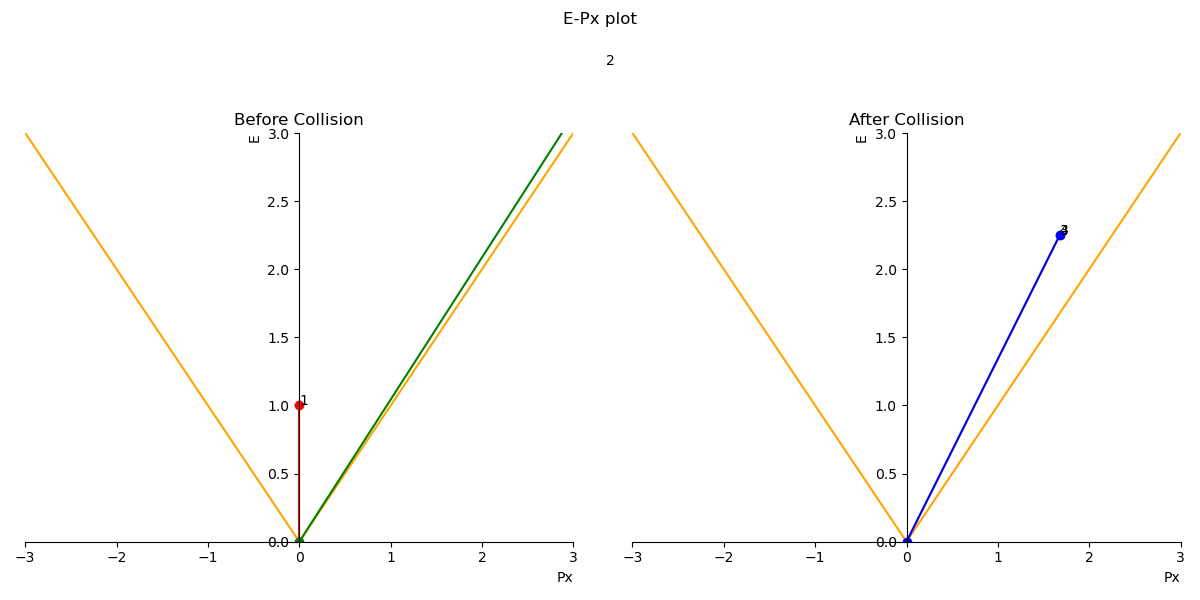

In [16]:


%matplotlib qt
user_input=input('Which Plot do you want?:1:3D, 2:Py-Px 3:E-Px 4:E-Py')
if user_input=='2':
    fig, (ax1, ax2) = plt.subplots(1, 2, num='Px-Py',figsize=(12, 6))
    _=ax1.plot(Px_bef_1,Py_bef_1,'ro')
    _=ax1.text(Px_bef_1,Py_bef_1,'1')
    _=ax1.plot(Px_bef_2,Py_bef_2,'go')
    _=ax1.text(Px_bef_2,Py_bef_2,'2')
    _=ax1.spines['left'].set_position(('data', 0))
    _=ax1.spines['bottom'].set_position(('data', 0))
    _=ax1.spines['right'].set_color('none')
    _=ax1.spines['top'].set_color('none')
    _=ax1.xaxis.set_ticks_position('bottom')
    _=ax1.yaxis.set_ticks_position('left')
 
    _=ax2.plot(Px_aft_3,Py_aft_3,'yo')
    _=ax2.text(Px_aft_3,Py_aft_3,'3')
    _=ax2.plot(Px_aft_4,Py_aft_4,'bo')
    _=ax2.text(Px_aft_4,Py_aft_4,'4')
    _=ax2.spines['left'].set_position(('data', 0))
    _=ax2.spines['bottom'].set_position(('data', 0))
    _=ax2.spines['right'].set_color('none')
    _=ax2.spines['top'].set_color('none')
    _=ax2.xaxis.set_ticks_position('bottom')
    _=ax2.yaxis.set_ticks_position('left')

    _=ax1.set_xlim(-3,3)
    _=ax1.set_ylim(-3,3)
    _=ax2.set_xlim(-3,3)
    _=ax2.set_ylim(-3,3)
    _=ax1.set_title('Before Collision')
    _=ax2.set_title('After Collision')
    _=ax1.set_xlabel('Px',loc='right')
    _=ax1.set_ylabel('Py',loc='top')
    _=ax2.set_xlabel('Px',loc='right')
    _=ax2.set_ylabel('Py',loc='top')
    _=fig.suptitle('Px-Py plot')
    plt.tight_layout()
    plt.show()
elif user_input=='3':
    fig, (ax1, ax2) = plt.subplots(1, 2, num='E-Px',figsize=(12, 6))
    _=ax1.axline([0, 0], [1, 1],color='orange')
    _=ax1.axline([0, 0], [-1, 1],color='orange')
    _=ax1.plot([0,Px_bef_1],[0,E1i_new],'ro-')
    _=ax1.text(Px_bef_1,E1i_new,'1')
    _=ax1.plot([0,Px_bef_2],[0,E2i_new],'go-')
    _=ax1.text(Px_bef_2,E2i_new,'2')
    _=ax1.spines['left'].set_position(('data', 0))
    _=ax1.spines['bottom'].set_position(('data', 0))
    _=ax1.spines['right'].set_color('none')
    _=ax1.spines['top'].set_color('none')
    _=ax1.xaxis.set_ticks_position('bottom')
    _=ax1.yaxis.set_ticks_position('left')

    _=ax2.axline([0, 0], [1, 1],color='orange')
    _=ax2.axline([0, 0], [-1, 1],color='orange')
    _=ax2.plot([0,Px_aft_3],[0,E3f_new],'yo-')
    _=ax2.text(Px_aft_3,E3f_new,'3')
    _=ax2.plot([0,Px_aft_4],[0,E4f_new],'bo-')
    _=ax2.text(Px_aft_4,E4f_new,'4')
    _=ax2.spines['left'].set_position(('data', 0))
    _=ax2.spines['bottom'].set_position(('data', 0))
    _=ax2.spines['right'].set_color('none')
    _=ax2.spines['top'].set_color('none')
    _=ax2.xaxis.set_ticks_position('bottom')
    _=ax2.yaxis.set_ticks_position('left')

    _=ax1.set_xlim(-3,3)
    _=ax1.set_ylim(-0,3)
    _=ax2.set_xlim(-3,3)
    _=ax2.set_ylim(0,3)
    _=ax1.set_title('Before Collision')
    _=ax2.set_title('After Collision')
    _=ax1.set_xlabel('Px',loc='right')
    _=ax1.set_ylabel('E',loc='top')
    _=ax2.set_xlabel('Px',loc='right')
    _=ax2.set_ylabel('E',loc='top')
    _=fig.suptitle('E-Px plot')
    plt.tight_layout()
    plt.show()
elif user_input=='4':
    fig, (ax1, ax2) = plt.subplots(1, 2, num='E-Py',figsize=(12, 6))
    _=ax1.axline([0, 0], [1, 1],color='orange')
    _=ax1.axline([0, 0], [-1, 1],color='orange')
    _=ax1.plot([0,Py_bef_1],[0,E1i_new],'ro-')
    _=ax1.text(Py_bef_1,E1i_new,'1')
    _=ax1.plot([0,Py_bef_2],[0,E2i_new],'go-')
    _=ax1.text(Py_bef_2,E2i_new,'2')
    _=ax1.spines['left'].set_position(('data', 0))
    _=ax1.spines['bottom'].set_position(('data', 0))
    _=ax1.spines['right'].set_color('none')
    _=ax1.spines['top'].set_color('none')
    _=ax1.xaxis.set_ticks_position('bottom')
    _=ax1.yaxis.set_ticks_position('left')

    _=ax2.axline([0, 0], [1, 1],color='orange')
    _=ax2.axline([0, 0], [-1, 1],color='orange')
    _=ax2.plot([0,Py_aft_3],[0,E3f_new],'yo-')
    _=ax2.text(Py_aft_3,E3f_new,'3')
    _=ax2.plot([0,Py_aft_4],[0,E4f_new],'bo-')
    _=ax2.text(Py_aft_4,E4f_new,'4')
    _=ax2.spines['left'].set_position(('data', 0))
    _=ax2.spines['bottom'].set_position(('data', 0))
    _=ax2.spines['right'].set_color('none')
    _=ax2.spines['top'].set_color('none')
    _=ax2.xaxis.set_ticks_position('bottom')
    _=ax2.yaxis.set_ticks_position('left')

    _=ax1.set_xlim(-3,3)
    _=ax1.set_ylim(-0,3)
    _=ax2.set_xlim(-3,3)
    _=ax2.set_ylim(0,3)
    _=ax1.set_title('Before Collision')
    _=ax2.set_title('After Collision')
    _=ax1.set_xlabel('Py',loc='right')
    _=ax1.set_ylabel('E',loc='top')
    _=ax2.set_xlabel('Py',loc='right')
    _=ax2.set_ylabel('E',loc='top')
    _=fig.suptitle('E-Py plot')
    plt.tight_layout()
    plt.show()
elif user_input=='1':
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,5),subplot_kw=dict(projection='3d'))

# syntax for 3-D projection
    _=ax1.plot3D(Px_bef_1,Py_bef_1,E1i_new,'ro-')
    _=ax1.text(Px_bef_1,Py_bef_1,E1i_new,'1')
    _=ax1.plot(Px_bef_2,Py_bef_2,E2i_new,'go-')
    _=ax1.text(Px_bef_2,Py_bef_2,E2i_new,'2')

    _=ax1.set_xlabel('Px')
    _=ax1.set_ylabel('Py')
    _=ax1.set_zlabel('E')
    _=ax1.set_xlim(-3,3)
    _=ax1.set_ylim(-3,3)
    _=ax1.set_zlim(0,3)
    #_=ax1.grid(color='orange')

    _=ax2.plot3D(Px_aft_3,Py_aft_3,E3f_new,'yo-')
    _=ax2.text(Px_aft_3,Py_aft_3,E3f_new,'3')
    _=ax2.plot(Px_aft_4,Py_aft_4,E4f_new,'bo-')
    _=ax2.text(Px_aft_4,Py_aft_4,E4f_new,'4')
    _=ax2.set_xlabel('Px')
    _=ax2.set_ylabel('Py')
    _=ax2.set_zlabel('E')
    _=ax2.set_xlim(-3,3)
    _=ax2.set_ylim(-3,3)
    _=ax2.set_zlim(0,3)
    plt.show()
    


## <span style="color:red">Plotting the energy vs scattered angle distribution plots</span>

#### <span style="color:red"> Here you invoke data from the output file saved from earlier and plot the variation of scattered angle with the energy of the emitted particle </span> **Note**: Before you run this section, make  sure you hav enough data points for various energies, which you can then use to plot and compare

In [ ]:
%matplotlib widget
user_input1=input('What is the initial energy you want to plot for?')
with open('Output_{}.txt'.format(user_input1),'r') as file:
    header=file.readline()
    x1=[]
    y1=[]
    for line in file:
        line=line.strip().split()
        x1.append(line[0])
        y1.append(line[1])


###Uncomment below if you want to plot the distribution plot for another incident energy

user_input2=input('What is the initial energy for the second plot?')
with open('Output_{}.txt'.format(user_input2),'r') as file:
    header=file.readline()
    x2=[]
    y2=[]
    for line in file:
        line=line.strip().split()
        x2.append(line[0])
        y2.append(line[1])



x1 = [float(i) for i in x1]
y1 = [float(i) for i in y1]
x2 = [float(i) for i in x2]
y2 = [float(i) for i in y2]

fig,ax=plt.subplots(1,1,figsize=(6,6))
ax.scatter(x1,y1,s=30,c='blue',marker='o',label='Eo={} MeV'.format(user_input1));
ax.plot(x1,y1,c='blue',alpha=0.2);
ax.scatter(x2,y2,s=30,c='orange',marker='o',label='Eo={} MeV'.format(user_input2));
ax.plot(x2,y2,c='orange',alpha=0.2);
ax.set_xlabel('Angle(degrees)');
ax.set_ylabel('Scattered particle energy (MeV)');
ax.set_title('Scattering particle energy vs. scattering angle');
ax.legend();